# Classes for callback implementors

In [ ]:
from fastai.gen_doc.nbdoc import *
from fastai.callback import * 
from fastai import *

fastai provides a powerful *callback* system, which is documented on the [`callbacks`](/callbacks.html#callbacks) page; look on that page if you're just looking for how to use existing callbacks. If you want to create your own, you'll need to use the classes discussed below.

A key motivation for the callback system is that additional functionality can be entirely implemented in a single callback, so that it's easily read. By using this trick, we will have different methods categorized in different callbacks where we will find clearly stated all the interventions the method makes in training. For instance in the [`LRFinder`](/callbacks.lr_finder.html#LRFinder) callback, on top of running the fit function with exponentially growing LRs, it needs to handle some preparation and clean-up, and all this code can be in the same callback so we know exactly what it is doing and where to look if we need to change something.

In addition, it allows our [`fit`](/basic_train.html#fit) function to be very clean and simple, yet still easily extended. So far in implementing a number of recent papers, we haven't yet come across any situation where we had to modify our training loop source code - we've been able to use callbacks every time.

In [ ]:
show_doc(Callback)

<h2 id="Callback"><code>class</code> <code>Callback</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L117" class="source_link">[source]</a></h2>

> <code>Callback</code>()

Base class for callbacks that want to record values, dynamically change learner params, etc.  

To create a new type of callback, you'll need to inherit from this class, and implement one or more methods as required for your purposes. Perhaps the easiest way to get started is to look at the source code for some of the pre-defined fastai callbacks. You might be surprised at how simple they are! For instance, here is the **entire** source code for [`GradientClipping`](/train.html#GradientClipping):

```python
@dataclass
class GradientClipping(LearnerCallback):
    clip:float
    def on_backward_end(self, **kwargs):
        if self.clip:
            nn.utils.clip_grad_norm_(self.learn.model.parameters(), self.clip)
```

You generally want your custom callback constructor to take a [`Learner`](/basic_train.html#Learner) parameter, e.g.:

```python
@dataclass
class MyCallback(Callback):
    learn:Learner
```

Note that this allows the callback user to just pass your callback name to `callback_fns` when constructing their [`Learner`](/basic_train.html#Learner), since that always passes `self` when constructing callbacks from `callback_fns`. In addition, by passing the learner, this callback will have access to everything: e.g all the inputs/outputs as they are calculated, the losses, and also the data loaders, the optimizer, etc. At any time:
- Changing self.learn.data.train_dl or self.data.valid_dl will change them inside the fit function (we just need to pass the [`DataBunch`](/basic_data.html#DataBunch) object to the fit function and not data.train_dl/data.valid_dl)
- Changing self.learn.opt.opt (We have an [`OptimWrapper`](/callback.html#OptimWrapper) on top of the actual optimizer) will change it inside the fit function.
- Changing self.learn.data or self.learn.opt directly WILL NOT change the data or the optimizer inside the fit function.

In any of the callbacks you can unpack in the kwargs:
- `n_epochs`, contains the number of epochs the training will take in total
- `epoch`, contains the number of the current
- `iteration`, contains the number of iterations done since the beginning of training
- `num_batch`, contains the number of the batch we're at in the dataloader
- `last_input`, contains the last input that got through the model (eventually updated by a callback)
- `last_target`, contains the last target that gor through the model (eventually updated by a callback)
- `last_output`, contains the last output spitted by the model (eventually updated by a callback)
- `last_loss`, contains the last loss computed (eventually updated by a callback)
- `smooth_loss`, contains the smoothed version of the loss
- `last_metrics`, contains the last validation loss and emtrics computed
- `pbar`, the progress bar

### Methods your subclass can implement

All of these methods are optional; your subclass can handle as many or as few as you require.

In [ ]:
show_doc(Callback.on_train_begin)

<h4 id="Callback.on_train_begin"><code>on_train_begin</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L120" class="source_link">[source]</a></h4>

> <code>on_train_begin</code>(`kwargs`:`Any`)

To initialize constants in the callback.  

Here we can initiliaze anything we need. 
The optimizer has now been initialized. We can change any hyper-parameters by typing, for instance:

```
self.opt.lr = new_lr
self.opt.mom = new_mom
self.opt.wd = new_wd
self.opt.beta = new_beta
```

In [ ]:
show_doc(Callback.on_epoch_begin)

<h4 id="Callback.on_epoch_begin"><code>on_epoch_begin</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L123" class="source_link">[source]</a></h4>

> <code>on_epoch_begin</code>(`kwargs`:`Any`)

At the beginning of each epoch.  

This is not technically required since we have `on_train_begin` for epoch 0 and `on_epoch_end` for all the other epochs,
yet it makes writing code that needs to be done at the beginning of every epoch easy and more readable.

In [ ]:
show_doc(Callback.on_batch_begin)

<h4 id="Callback.on_batch_begin"><code>on_batch_begin</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L126" class="source_link">[source]</a></h4>

> <code>on_batch_begin</code>(`kwargs`:`Any`)

Set HP before the step is done. Returns xb, yb (which can allow us to modify the input at that step if needed).  

Here is the perfect place to prepare everything before the model is called.
Example: change the values of the hyperparameters (if we don't do it on_batch_end instead)

If we return something, that will be the new value for `xb`,`yb`. 

In [ ]:
show_doc(Callback.on_loss_begin)

<h4 id="Callback.on_loss_begin"><code>on_loss_begin</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L129" class="source_link">[source]</a></h4>

> <code>on_loss_begin</code>(`kwargs`:`Any`)

Called after forward pass but before loss has been computed. Returns the output (which can allow us to modify it).  

Here is the place to run some code that needs to be executed after the output has been computed but before the
loss computation.
Example: putting the output back in FP32 when training in mixed precision.

If we return something, that will be the new value for the output.

In [ ]:
show_doc(Callback.on_backward_begin)

<h4 id="Callback.on_backward_begin"><code>on_backward_begin</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L132" class="source_link">[source]</a></h4>

> <code>on_backward_begin</code>(`kwargs`:`Any`)

Called after the forward pass and the loss has been computed, but before backprop. Returns the loss (which can allow us to modify it, for instance for reg functions) 

Here is the place to run some code that needs to be executed after the loss has been computed but before the gradient computation.
Example: `reg_fn` in RNNs.

If we return something, that will be the new value for loss. Since the recorder is always called first,
it will have the raw loss.

In [ ]:
show_doc(Callback.on_backward_end)

<h4 id="Callback.on_backward_end"><code>on_backward_end</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L136" class="source_link">[source]</a></h4>

> <code>on_backward_end</code>(`kwargs`:`Any`)

Called after backprop but before optimizer step. Useful for true weight decay in AdamW.  

Here is the place to run some code that needs to be executed after the gradients have been computed but
before the optimizer is called.

In [ ]:
show_doc(Callback.on_step_end)

<h4 id="Callback.on_step_end"><code>on_step_end</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L139" class="source_link">[source]</a></h4>

> <code>on_step_end</code>(`kwargs`:`Any`)

Called after the step of the optimizer but before the gradients are zeroed.  

Here is the place to run some code that needs to be executed after the optimizer step but before the gradients
are zeroed

In [ ]:
show_doc(Callback.on_batch_end)

<h4 id="Callback.on_batch_end"><code>on_batch_end</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L142" class="source_link">[source]</a></h4>

> <code>on_batch_end</code>(`kwargs`:`Any`)

Called at the end of the batch.  

Here is the place to run some code that needs to be executed after a batch is fully done.
Example: change the values of the hyperparameters (if we don't do it on_batch_begin instead)

If we return true, the current epoch is interrupted (example: lr_finder stops the training when the loss explodes)

In [ ]:
show_doc(Callback.on_epoch_end)

<h4 id="Callback.on_epoch_end"><code>on_epoch_end</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L145" class="source_link">[source]</a></h4>

> <code>on_epoch_end</code>(`kwargs`:`Any`) → `bool`

Called at the end of an epoch.  

Here is the place to run some code that needs to be executed at the end of an epoch.
Example: Save the model if we have a new best validation loss/metric.

If we return true, the training stops (example: early stopping)

In [ ]:
show_doc(Callback.on_train_end)

<h4 id="Callback.on_train_end"><code>on_train_end</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L148" class="source_link">[source]</a></h4>

> <code>on_train_end</code>(`kwargs`:`Any`)

Useful for cleaning up things and saving files/models.  

Here is the place to tidy everything. It's always executed even if there was an error during the training loop,
and has an extra kwarg named exception to check if there was an exception or not.
Examples: save log_files, load best model found during training

## Annealing functions

The following functions provide different annealing schedules. You probably won't need to call them directly, but would instead use them as part of a callback. Here's what each one looks like:

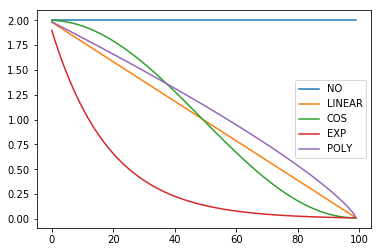

In [ ]:
annealings = "NO LINEAR COS EXP POLY".split()
fns = [annealing_no, annealing_linear, annealing_cos, annealing_exp, annealing_poly(0.8)]
for fn, t in zip(fns, annealings):
    plt.plot(np.arange(0, 100), [fn(2, 1e-2, o)
        for o in np.linspace(0.01,1,100)], label=t)
plt.legend();

In [ ]:
show_doc(annealing_cos)

<h4 id="annealing_cos"><code>annealing_cos</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L284" class="source_link">[source]</a></h4>

> <code>annealing_cos</code>(`start`:`Number`, `end`:`Number`, `pct`:`float`) → `Number`

Cosine anneal from `start` to `end` as pct goes from 0.0 to 1.0.  

In [ ]:
show_doc(annealing_exp)

<h4 id="annealing_exp"><code>annealing_exp</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L281" class="source_link">[source]</a></h4>

> <code>annealing_exp</code>(`start`:`Number`, `end`:`Number`, `pct`:`float`) → `Number`

Exponentially anneal from `start` to `end` as pct goes from 0.0 to 1.0.  

In [ ]:
show_doc(annealing_linear)

<h4 id="annealing_linear"><code>annealing_linear</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L278" class="source_link">[source]</a></h4>

> <code>annealing_linear</code>(`start`:`Number`, `end`:`Number`, `pct`:`float`) → `Number`

Linearly anneal from `start` to `end` as pct goes from 0.0 to 1.0.  

In [ ]:
show_doc(annealing_no)

<h4 id="annealing_no"><code>annealing_no</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L275" class="source_link">[source]</a></h4>

> <code>annealing_no</code>(`start`:`Number`, `end`:`Number`, `pct`:`float`) → `Number`

No annealing, always return `start`.  

In [ ]:
show_doc(annealing_poly)

<h4 id="annealing_poly"><code>annealing_poly</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L292" class="source_link">[source]</a></h4>

> <code>annealing_poly</code>(`degree`:`Number`) → `Number`

Anneal polynomically from `start` to `end` as pct goes from 0.0 to 1.0.  

In [ ]:
show_doc(CallbackHandler)

<h2 id="CallbackHandler"><code>class</code> <code>CallbackHandler</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L169" class="source_link">[source]</a></h2>

> <code>CallbackHandler</code>(`callbacks`:`Collection`\[[`Callback`](/callback.html#Callback)\]=`None`, `metrics`:`Collection`\[[`Callback`](/callback.html#Callback)\]=`None`, `beta`:`float`=`0.98`)

Manage all of the registered callback objects, smoothing loss by momentum `beta`.  

You probably won't need to use this class yourself. It's used by fastai to combine all the callbacks together and call any relevant callback functions for each training stage. The methods below simply call the equivalent method in each callback function in [`self.callbacks`](/callbacks.html#callbacks). 

In [ ]:
show_doc(CallbackHandler.on_backward_begin)

<h4 id="CallbackHandler.on_backward_begin"><code>on_backward_begin</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L219" class="source_link">[source]</a></h4>

> <code>on_backward_begin</code>(`loss`:`Tensor`)

Handle gradient calculation on `loss`.  

In [ ]:
show_doc(CallbackHandler.on_backward_end)

<h4 id="CallbackHandler.on_backward_end"><code>on_backward_end</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L228" class="source_link">[source]</a></h4>

> <code>on_backward_end</code>()

Handle end of gradient calculation.  

In [ ]:
show_doc(CallbackHandler.on_batch_begin)

<h4 id="CallbackHandler.on_batch_begin"><code>on_batch_begin</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L201" class="source_link">[source]</a></h4>

> <code>on_batch_begin</code>(`xb`:`Tensor`, `yb`:`Tensor`, `train`:`bool`=`True`)

Handle new batch `xb`,`yb`.  

In [ ]:
show_doc(CallbackHandler.on_batch_end)

<h4 id="CallbackHandler.on_batch_end"><code>on_batch_end</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L235" class="source_link">[source]</a></h4>

> <code>on_batch_end</code>(`loss`:`Tensor`)

Handle end of processing one batch with `loss`.  

In [ ]:
show_doc(CallbackHandler.on_epoch_begin)

<h4 id="CallbackHandler.on_epoch_begin"><code>on_epoch_begin</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L196" class="source_link">[source]</a></h4>

> <code>on_epoch_begin</code>()

Handle new epoch.  

In [ ]:
show_doc(CallbackHandler.on_epoch_end)

<h4 id="CallbackHandler.on_epoch_end"><code>on_epoch_end</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L244" class="source_link">[source]</a></h4>

> <code>on_epoch_end</code>(`val_loss`:`Tensor`) → `bool`

Epoch is done, process `val_metrics`.  

In [ ]:
show_doc(CallbackHandler.on_loss_begin)

<h4 id="CallbackHandler.on_loss_begin"><code>on_loss_begin</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L211" class="source_link">[source]</a></h4>

> <code>on_loss_begin</code>(`out`:`Tensor`)

Handle start of loss calculation with model output `out`.  

In [ ]:
show_doc(CallbackHandler.on_step_end)

<h4 id="CallbackHandler.on_step_end"><code>on_step_end</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L231" class="source_link">[source]</a></h4>

> <code>on_step_end</code>()

Handle end of optimization step.  

In [ ]:
show_doc(CallbackHandler.on_train_begin)

<h4 id="CallbackHandler.on_train_begin"><code>on_train_begin</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L189" class="source_link">[source]</a></h4>

> <code>on_train_begin</code>(`epochs`:`int`, `pbar`:`PBar`, `metrics`:`MetricFuncList`)

About to start learning.  

In [ ]:
show_doc(CallbackHandler.on_train_end)

<h4 id="CallbackHandler.on_train_end"><code>on_train_end</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L254" class="source_link">[source]</a></h4>

> <code>on_train_end</code>(`exception`:`Union`\[`bool`, `Exception`\])

Handle end of training, `exception` is an `Exception` or False if no exceptions during training.  

In [ ]:
show_doc(OptimWrapper)

<h2 id="OptimWrapper"><code>class</code> <code>OptimWrapper</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L8" class="source_link">[source]</a></h2>

> <code>OptimWrapper</code>(`opt`:[`Optimizer`](https://pytorch.org/docs/stable/optim.html#torch.optim.Optimizer), `wd`:`Floats`=`0.0`, `true_wd`:`bool`=`False`, `bn_wd`:`bool`=`True`)

Basic wrapper around an optimizer to simplify HP changes.  

This is a convenience class that provides a consistent API for getting and setting optimizer hyperparameters. For instance, for [`optim.Adam`](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) the momentum parameter is actually `betas[0]`, whereas for [`optim.SGD`](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD) it's simply `momentum`. As another example, the details of handling weight decay depend on whether you are using `true_wd` or the traditional L2 regularization approach.

This class also handles setting different WD and LR for each layer group, for discriminative layer training.

In [ ]:
show_doc(OptimWrapper.create)

<h4 id="OptimWrapper.create"><code>create</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L17" class="source_link">[source]</a></h4>

> <code>create</code>(`opt_func`:`Callable`, `lr`:`Union`\[`float`, `Tuple`, `List`\], `layer_groups`:`ModuleList`, `kwargs`:`Any`) → [`Optimizer`](https://pytorch.org/docs/stable/optim.html#torch.optim.Optimizer)

Create an optim.Optimizer from `opt_func` with `lr`. Set lr on `layer_groups`.  

In [ ]:
show_doc(OptimWrapper.read_defaults)

<h4 id="OptimWrapper.read_defaults"><code>read_defaults</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L94" class="source_link">[source]</a></h4>

> <code>read_defaults</code>()

Read the values inside the optimizer for the hyper-parameters.  

In [ ]:
show_doc(OptimWrapper.read_val)

<h4 id="OptimWrapper.read_val"><code>read_val</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L111" class="source_link">[source]</a></h4>

> <code>read_val</code>(`key`:`str`) → `Union`\[`List`\[`float`\], `Tuple`\[`List`\[`float`\], `List`\[`float`\]\]\]

Read a hyperparameter key in the optimizer dictionary.  

In [ ]:
show_doc(OptimWrapper.set_val)

<h4 id="OptimWrapper.set_val"><code>set_val</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L103" class="source_link">[source]</a></h4>

> <code>set_val</code>(`key`:`str`, `val`:`Any`, `bn_groups`:`bool`=`True`) → `Any`

Set the values inside the optimizer dictionary at the key.  

In [ ]:
show_doc(OptimWrapper.step)

<h4 id="OptimWrapper.step"><code>step</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L31" class="source_link">[source]</a></h4>

> <code>step</code>()

Set weight decay and step optimizer.  

In [ ]:
show_doc(OptimWrapper.zero_grad)

<h4 id="OptimWrapper.zero_grad"><code>zero_grad</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L42" class="source_link">[source]</a></h4>

> <code>zero_grad</code>()

Clear optimizer gradients.  

In [ ]:
show_doc(SmoothenValue)

<h2 id="SmoothenValue"><code>class</code> <code>SmoothenValue</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L152" class="source_link">[source]</a></h2>

> <code>SmoothenValue</code>(`beta`:`float`)

Create a smooth moving average for a value (loss, etc).  

Used for smoothing loss in [`Recorder`](/basic_train.html#Recorder).

In [ ]:
show_doc(SmoothenValue.add_value)

<h4 id="SmoothenValue.add_value"><code>add_value</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L158" class="source_link">[source]</a></h4>

> <code>add_value</code>(`val`:`float`)

Add current value to calculate updated smoothed value.  

In [ ]:
show_doc(Stepper)

<h2 id="Stepper"><code>class</code> <code>Stepper</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L296" class="source_link">[source]</a></h2>

> <code>Stepper</code>(`vals`:`StartOptEnd`, `n_iter`:`int`, `func`:`Optional`\[`AnnealFunc`\]=`None`)

Used to "step" from start,end (`vals`) over `n_iter` iterations on a schedule defined by `func`  

Used for creating annealing schedules, mainly for [`OneCycleScheduler`](/callbacks.one_cycle.html#OneCycleScheduler).

In [ ]:
show_doc(Stepper.step)

<h4 id="Stepper.step"><code>step</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L305" class="source_link">[source]</a></h4>

> <code>step</code>() → `Number`

Return next value along annealed schedule.  

In [ ]:
show_doc(AverageMetric)

<h2 id="AverageMetric"><code>class</code> <code>AverageMetric</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L258" class="source_link">[source]</a></h2>

> <code>AverageMetric</code>(`func`) :: [`Callback`](/callback.html#Callback)

Wrap a `func` in a callback for metrics computation.  

See the documentation on [`metrics`](/metrics.html#metrics) for more information.

## Undocumented Methods - Methods moved below this line will intentionally be hidden

In [ ]:
show_doc(do_annealing_poly)

<h4 id="do_annealing_poly"><code>do_annealing_poly</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L289" class="source_link">[source]</a></h4>

> <code>do_annealing_poly</code>(`start`:`Number`, `end`:`Number`, `pct`:`float`, `degree`:`Number`) → `Number`

Helper function for `anneal_poly`.  

## New Methods - Please document or move to the undocumented section

In [ ]:
show_doc(AverageMetric.on_epoch_begin)

<h4 id="AverageMetric.on_epoch_begin"><code>on_epoch_begin</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L265" class="source_link">[source]</a></h4>

> <code>on_epoch_begin</code>(`kwargs`)

At the beginning of each epoch.  

In [ ]:
show_doc(AverageMetric.on_batch_end)

<h4 id="AverageMetric.on_batch_end"><code>on_batch_end</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L268" class="source_link">[source]</a></h4>

> <code>on_batch_end</code>(`last_output`, `last_target`, `train`, `kwargs`)

Called at the end of the batch.  

In [ ]:
show_doc(AverageMetric.on_epoch_end)

<h4 id="AverageMetric.on_epoch_end"><code>on_epoch_end</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L272" class="source_link">[source]</a></h4>

> <code>on_epoch_end</code>(`kwargs`)

Called at the end of an epoch.  